In [1]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 



2023-10-27 08:37:21.961380: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 08:37:22.133999: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-27 08:37:22.134032: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-27 08:37:22.135250: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-27 08:37:22.233708: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-27 08:37:22.236218: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
# folders
Ravdess = "dataset/Ravdess/audio_speech_actors_01-24/"
Crema = "dataset/Crema/"
Tess = "dataset/Tess/"
Savee = "dataset/Savee/"

In [3]:
#Ravdess Processing
ravdess_directory_list = os.listdir(Ravdess)

file_emotion = []
file_path = []
for dir in ravdess_directory_list:
    # as their are 20 different actors in our previous directory we need to extract files for each actor.
    actor = os.listdir(Ravdess + dir)
    for file in actor:
        part = file.split('.')[0]
        part = part.split('-')
        # third part in each file represents the emotion associated to that file.
        if int(part[2]) == 2 or int(part[2]) == 8: continue
        # REMOVE suprise AND CALM
        file_emotion.append(int(part[2]))
        file_path.append(Ravdess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Ravdess_df = pd.concat([emotion_df, path_df], axis=1)

# changing integers to actual emotions.
Ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
Ravdess_df.head()


,Emotions,Path
0,happy,dataset/Ravdess/audio_speech_actors_01-24/Acto...
1,sad,dataset/Ravdess/audio_speech_actors_01-24/Acto...
2,angry,dataset/Ravdess/audio_speech_actors_01-24/Acto...
3,happy,dataset/Ravdess/audio_speech_actors_01-24/Acto...
4,happy,dataset/Ravdess/audio_speech_actors_01-24/Acto...


In [4]:
# Crema Processing
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()


,Emotions,Path
0,disgust,dataset/Crema/1035_ITH_DIS_XX.wav
1,sad,dataset/Crema/1085_MTI_SAD_XX.wav
2,neutral,dataset/Crema/1014_WSI_NEU_XX.wav
3,happy,dataset/Crema/1050_MTI_HAP_XX.wav
4,angry,dataset/Crema/1023_ITS_ANG_XX.wav


In [5]:
#tess processing
tess_directory_list = os.listdir(Tess)

file_emotion = []
file_path = []

for dir in tess_directory_list:
    directories = os.listdir(Tess + dir)
    for file in directories:
        part = file.split('.')[0]
        part = part.split('_')[2]
        if part=='ps':
            #file_emotion.append('surprise')
            continue
        else:
            file_emotion.append(part)
        file_path.append(Tess + dir + '/' + file)
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Tess_df = pd.concat([emotion_df, path_df], axis=1)
Tess_df.head()

#REMOVE SURPISE

,Emotions,Path
0,sad,dataset/Tess/YAF_sad/YAF_hurl_sad.wav
1,sad,dataset/Tess/YAF_sad/YAF_met_sad.wav
2,sad,dataset/Tess/YAF_sad/YAF_book_sad.wav
3,sad,dataset/Tess/YAF_sad/YAF_lean_sad.wav
4,sad,dataset/Tess/YAF_sad/YAF_pool_sad.wav


In [6]:
#savee processing
savee_directory_list = os.listdir(Savee)

file_emotion = []
file_path = []

for file in savee_directory_list:
    file_path.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotion.append('angry')
    elif ele=='d':
        file_emotion.append('disgust')
    elif ele=='f':
        file_emotion.append('fear')
    elif ele=='h':
        file_emotion.append('happy')
    elif ele=='n':
        file_emotion.append('neutral')
    elif ele=='sa':
        file_emotion.append('sad')
    #else:
        #file_emotion.append('surprise')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Savee_df = pd.concat([emotion_df, path_df], axis=1)
Savee_df.head()

,Emotions,Path
0,sad,dataset/Savee/JE_sa04.wav
1,neutral,dataset/Savee/JK_n29.wav
2,happy,dataset/Savee/JK_h13.wav
3,disgust,dataset/Savee/KL_d08.wav
4,neutral,dataset/Savee/KL_n02.wav


In [7]:
#to csv
data_path = pd.concat([Ravdess_df, Crema_df, Tess_df, Savee_df], axis = 0)
#data_path.to_csv("data_path.csv",index=False)
data_path.head()


,Emotions,Path
0,happy,dataset/Ravdess/audio_speech_actors_01-24/Acto...
1,sad,dataset/Ravdess/audio_speech_actors_01-24/Acto...
2,angry,dataset/Ravdess/audio_speech_actors_01-24/Acto...
3,happy,dataset/Ravdess/audio_speech_actors_01-24/Acto...
4,happy,dataset/Ravdess/audio_speech_actors_01-24/Acto...


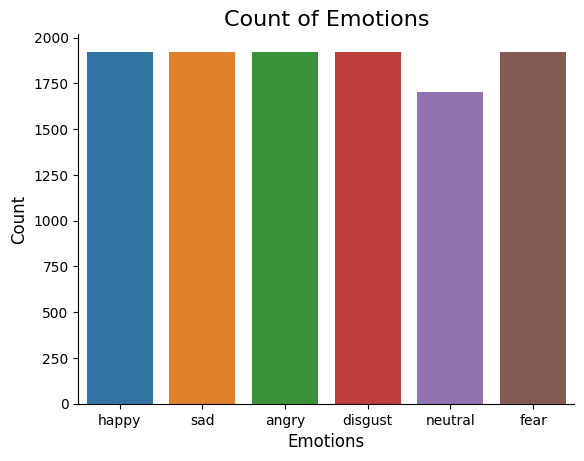

In [8]:
# display data
plt.title('Count of Emotions', size=16)
sns.countplot(x=data_path.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()


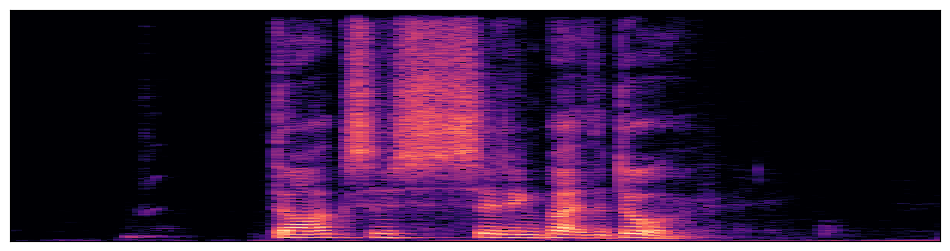

In [9]:
def create_waveplot(data, sr, e):
    #plt.figure(figsize=(10, 3))
    #plt.title(, size=15)
    #librosa.display.waveshow(data, sr=sr)
    #plt.show()
    pd.Series(data).plot(figsize=(10, 3),
                  lw=1,
                  title='Waveplot for audio with {} emotion'.format(e),
                  color="blue")
    plt.show()

def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    
    plt.figure(figsize=(12, 3))
    # plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr)   
    # plt.show()


        
#for bruh in processlist:
path = np.array(data_path.Path[data_path.Emotions=='fear'])[0]
data, sampling_rate = librosa.load(path)
create_spectrogram(data, sampling_rate, 'fear')





In [10]:




REGENERATE_IMAGES = False

if(REGENERATE_IMAGES):
    total = 0
    from IPython.display import clear_output
    emotions=['happy', 'sad', 'angry', 'disgust', 'neutral', 'fear']
    headpath = os.path.join(os.getcwd(), "emotions_png")
    if not os.path.isdir(headpath):
        os.mkdir(headpath)
    for em in emotions:
        p2 = os.path.join(headpath, em) 
        if not os.path.isdir(p2):
            os.mkdir(p2)
    
        ct = 0
        processlist = np.array(data_path.Path[data_path.Emotions==em])
        for path in processlist:
            data, sampling_rate = librosa.load(path)
            if os.path.isfile(f'emotions_png/{em}/image{ct}.png'):
                #this might be a point of issue if the array is random every time but hopefully that won't be an issue... right?
                clear_output(wait = True)
                ct += 1
                total += 1
                print(f"Percent Done: {(total/11378*100):.2f}%")
                continue
                #there is 100% a better way to do this but whatev
            
            create_spectrogram(data, sampling_rate, em)
            plt.savefig(f'emotions_png/{em}/image{ct}.png', bbox_inches='tight', pad_inches=0) 
            plt.clf()
            plt.cla()
            plt.close()
            #prevent memory leak
    
            ct += 1
            total += 1
            clear_output(wait = True)
            print(f"Percent Done: {(total/11378*100):.2f}%")


In [11]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(y=data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(y=data, sr=sampling_rate, n_steps=pitch_factor)

# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
data, sample_rate = librosa.load(path)

In [12]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result


In [15]:
%%time
X, Y = [], []
failedFiles = 0
totalFiles = 11378

REGENERATE_FEATURES = False

if os.path.isfile("features.csv") and not REGENERATE_FEATURES:
    print("features.csv exists, reading file")
    Features = pd.read_csv('features.csv')

else:
    fileCount = 0
    temp = 0
    from IPython.display import clear_output
    for path, emotion in zip(data_path.Path, data_path.Emotions):
        feature = get_features(path)
        fileCount = fileCount + 1
        for ele in feature:
            try:
                clear_output(wait = True)
                temp = ((fileCount / totalFiles) * 100)
                X.append(ele)
                # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
                Y.append(emotion)
                print(f"Progress: {temp:.2f}%")
    
            except:
                failedFiles = failedFiles + 1
                print(f'failed')
    #len(X), len(Y), data_path.Path.shape
    if(failedFiles > 0):
        print("failed files exist, preventing write to csv")
    else:
        Features = pd.DataFrame(X)
        Features['labels'] = Y
        Features.to_csv('features.csv', index=False)

    
print(f'Total emotion count >>> {totalFiles}\n')
print(f'Files failed to be processed >>> {failedFiles}\n')
Features.head()


features.csv exists, reading file
Total emotion count >>> 11378

Files failed to be processed >>> 0

CPU times: user 923 ms, sys: 202 ms, total: 1.13 s
Wall time: 1.15 s


,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.171586,0.467709,0.483418,0.572540,0.601726,0.606083,0.588570,0.573947,0.537542,0.553386,...,0.000204,0.000218,0.000208,0.000367,0.000419,0.000542,0.000450,0.000245,2.093455e-05,happy
1,0.187251,0.496343,0.576195,0.637760,0.654253,0.639352,0.596986,0.551663,0.568141,0.579013,...,0.000226,0.000245,0.000236,0.000396,0.000453,0.000580,0.000486,0.000274,4.664700e-05,happy
2,0.145092,0.509510,0.454902,0.516171,0.584915,0.616749,0.607900,0.609331,0.554467,0.560945,...,0.000044,0.000036,0.000042,0.000050,0.000069,0.000052,0.000081,0.000054,3.840095e-06,happy
3,0.066149,0.605754,0.637398,0.573927,0.533352,0.575843,0.675654,0.686962,0.601578,0.532368,...,0.000017,0.000014,0.000011,0.000010,0.000014,0.000013,0.000011,0.000009,8.813865e-07,sad
4,0.223949,0.676025,0.717963,0.694785,0.641435,0.652799,0.721492,0.713021,0.664477,0.602789,...,0.000238,0.000245,0.000241,0.000252,0.000249,0.000248,0.000239,0.000224,2.039698e-04,sad


In [16]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [17]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [18]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25600, 162), (25600, 7), (8534, 162), (8534, 7))

In [19]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((25600, 162), (25600, 7), (8534, 162), (8534, 7))

In [20]:
# making our data compatible to model.
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((25600, 162, 1), (25600, 7), (8534, 162, 1), (8534, 7))

In [21]:
x_train, y_train

(array([[[ 0.22066489],
         [-1.16519124],
         [-0.93772276],
         ...,
         [-0.23085819],
         [-0.22351467],
         [-0.20949209]],
 
        [[-0.06031567],
         [ 0.93454861],
         [ 0.51840081],
         ...,
         [-0.23092522],
         [-0.22358144],
         [-0.20956034]],
 
        [[ 0.37822267],
         [-0.50584808],
         [-0.08165614],
         ...,
         [-0.20892242],
         [-0.21158204],
         [-0.2085902 ]],
 
        ...,
 
        [[ 1.11703859],
         [-0.77285411],
         [ 0.9977009 ],
         ...,
         [ 0.21349938],
         [ 0.19817917],
         [ 0.22637739]],
 
        [[-0.85346008],
         [-0.05384111],
         [ 0.04159378],
         ...,
         [-0.23091169],
         [-0.22356743],
         [-0.20954523]],
 
        [[ 0.36357552],
         [ 0.51108432],
         [ 0.09351754],
         ...,
         [-0.22271651],
         [-0.2184753 ],
         [-0.20921719]]]),
 array([[0., 0., 0.

In [22]:
model=Sequential()
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.5))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.5))

'''
model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.5))
    
model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
'''

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=7, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 64)           384       
                                                                 
 max_pooling1d (MaxPooling1  (None, 81, 64)            0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 81, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 41, 128)           0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 41, 128)           0

In [31]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
x_train = np.asarray(x_train).astype('float32')
x_test = np.asarray(x_test).astype('float32')

import tensorflow as tf
x_train=tf.convert_to_tensor(x_train, dtype=tf.float32)
x_test=tf.convert_to_tensor(x_test, dtype=tf.float32)


history=model.fit(x_train, y_train, batch_size=64, epochs=50, validation_data=(x_test, y_test), callbacks=[rlrp])

Epoch 1/50
265/400 [==================>...........] - ETA: 3s - loss: 1.2591 - accuracy: 0.4817

KeyboardInterrupt: 

267/267 [==============================] - 1s 3ms/step - loss: 1.1655 - accuracy: 0.5386
Accuracy of our model on test data :  53.85516881942749 %


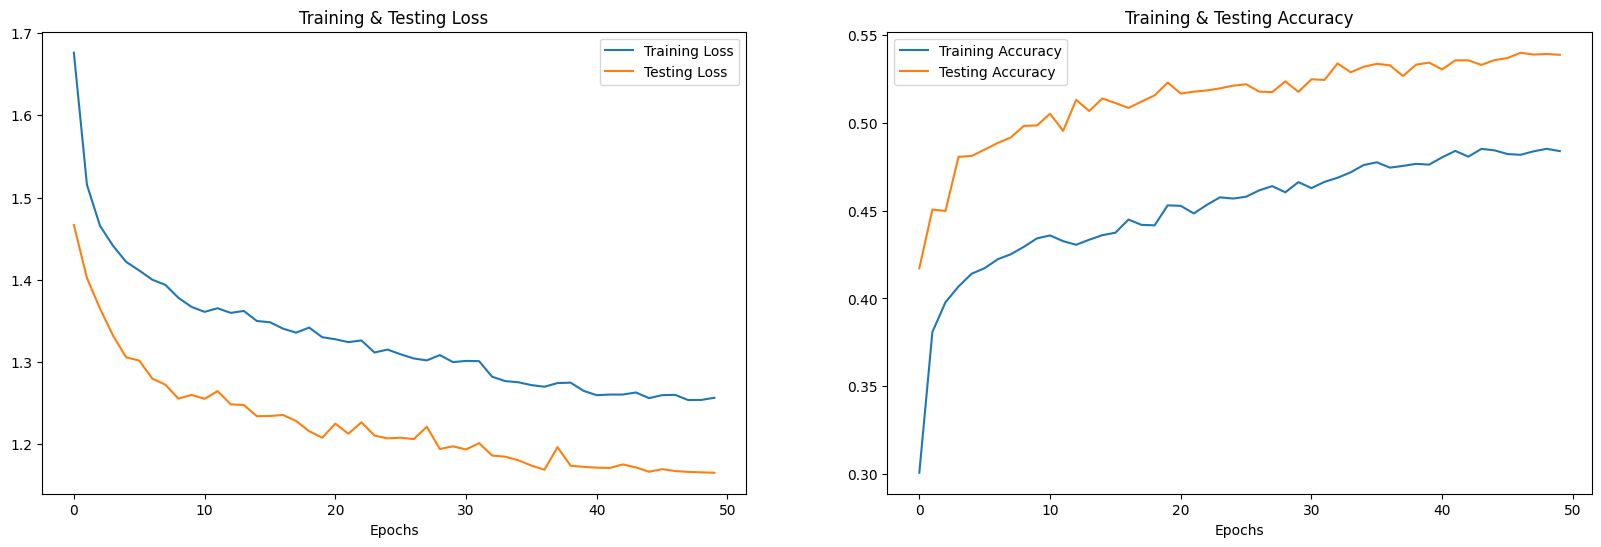

In [24]:
print("Accuracy of our model on test data : " , model.evaluate(x_test,y_test)[1]*100 , "%")

epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [69]:
# predicting on test data.
pred_test = model.predict(x_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

267/267 [==============================] - 1s 3ms/step


ValueError: Expected 2D array, got 1D array instead:
array=[4 1 7 ... 5 7 7].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [68]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()
map = {v: k for k, v in {1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}.items()}

bruh = []
for i in y_test:
    try:
        bruh.append(map[i[0]])
    except KeyError:
        print(i)
y_test = bruh

bruh = []

for i in y_pred:
    try:
        bruh.append(map[i[0]])
    except KeyError:
        continue
y_pred = bruh
#y_pred


AttributeError: 'list' object has no attribute 'flatten'

In [67]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [8496, 8534]

In [ ]:
print(classification_report(y_test, y_pred))

